<a href="https://colab.research.google.com/github/EsterCim/MERW-on-networks/blob/main/Amazon_dataset_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Now this is the code to analyse the real network of products co-purchasing of amazon**


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Number of nodes: 262,111
Number of edges: 1,234,877
Average degree: 9.42
Is strongly connected? False
Number of strongly connected components: 6594


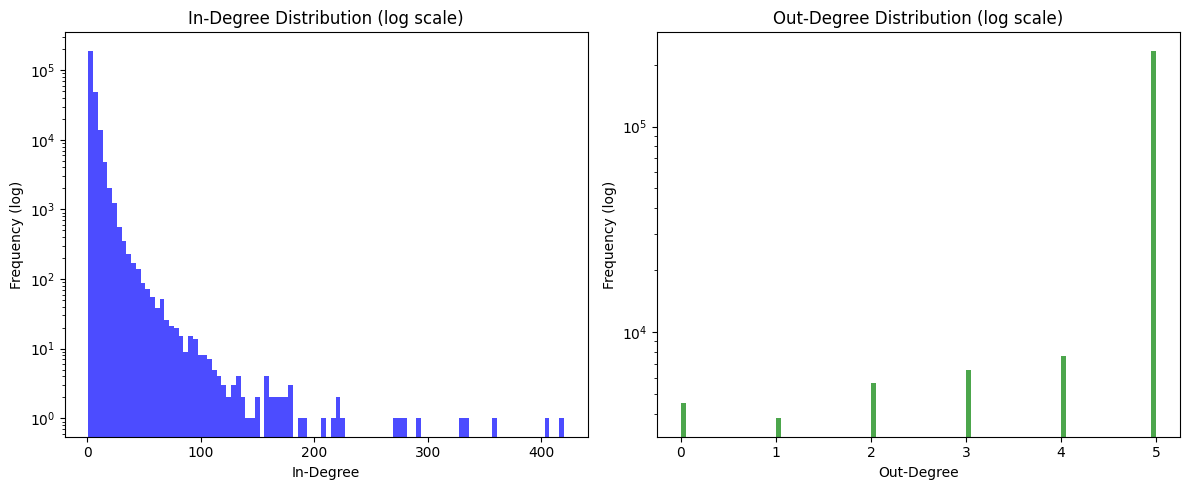

In [7]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


file_path = "/content/drive/MyDrive/Complex_Networks/Amazon0302.txt"


G = nx.read_edgelist(
    file_path,
    delimiter='\t',
    comments='#',
    create_using=nx.DiGraph(),
    nodetype=int
)


print(f"Number of nodes: {G.number_of_nodes():,}")
print(f"Number of edges: {G.number_of_edges():,}")
print(f"Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")
print(f"Is strongly connected? {nx.is_strongly_connected(G)}")
print(f"Number of strongly connected components: {nx.number_strongly_connected_components(G)}")


in_degrees = [d for _, d in G.in_degree()]
out_degrees = [d for _, d in G.out_degree()]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(in_degrees, bins=100, log=True, color='blue', alpha=0.7)
plt.title("In-Degree Distribution (log scale)")
plt.xlabel("In-Degree")
plt.ylabel("Frequency (log)")

plt.subplot(1, 2, 2)
plt.hist(out_degrees, bins=100, log=True, color='green', alpha=0.7)
plt.title("Out-Degree Distribution (log scale)")
plt.xlabel("Out-Degree")
plt.ylabel("Frequency (log)")

plt.tight_layout()
plt.show()


Since the graph is not strongly connected, I'm gonna separate the largest strongly connected components and analyse it.


Number of strongly connected components: 6594
Size of largest strongly connected component: 241761
Nodes in SCC: 241761
Edges in SCC: 1131217
Average degree: 9.36
Is strongly connected? True


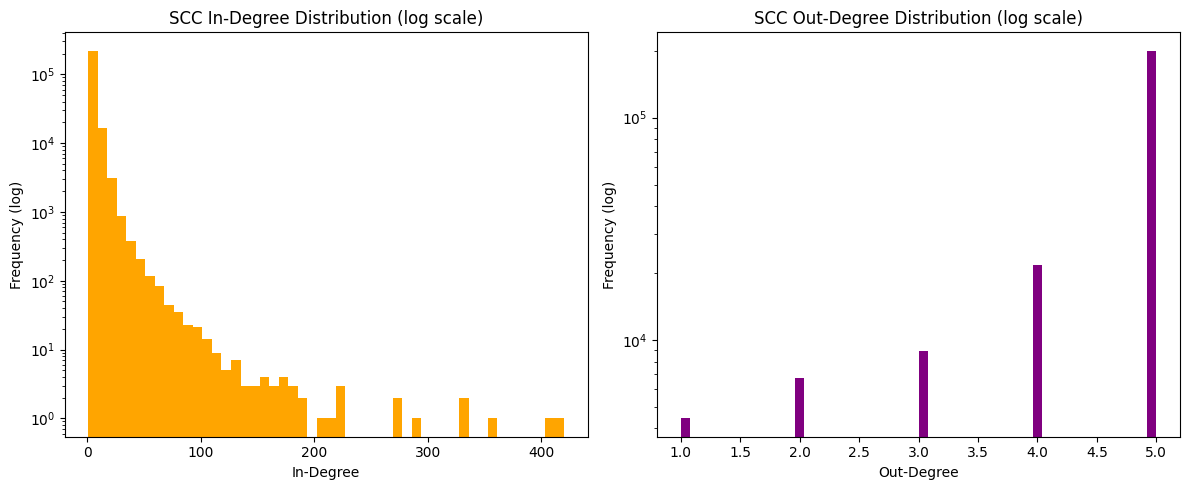

In [8]:

sccs = list(nx.strongly_connected_components(G))
largest_scc = max(sccs, key=len)

print(f"Number of strongly connected components: {len(sccs)}")
print(f"Size of largest strongly connected component: {len(largest_scc)}")

G_scc = G.subgraph(largest_scc).copy()


print(f"Nodes in SCC: {G_scc.number_of_nodes()}")
print(f"Edges in SCC: {G_scc.number_of_edges()}")
print(f"Average degree: {sum(dict(G_scc.degree()).values()) / G_scc.number_of_nodes():.2f}")
print(f"Is strongly connected? {nx.is_strongly_connected(G_scc)}")


in_degrees = [d for _, d in G_scc.in_degree()]
out_degrees = [d for _, d in G_scc.out_degree()]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(in_degrees, bins=50, log=True, color='orange')
plt.title("SCC In-Degree Distribution (log scale)")
plt.xlabel("In-Degree")
plt.ylabel("Frequency (log)")

plt.subplot(1, 2, 2)
plt.hist(out_degrees, bins=50, log=True, color='purple')
plt.title("SCC Out-Degree Distribution (log scale)")
plt.xlabel("Out-Degree")
plt.ylabel("Frequency (log)")

plt.tight_layout()
plt.show()

## **MERW**

Now, I would like to see a phenomen of localization on the network. This code is just to see the stationary distribution among nodes. On the x axis of the graph one can see all the nodes of the largest SCC ordered from rank 1 (the node with highest probability density) till the last rank. We can see from the distribution few nodes have a high probability distribution and then there is a dramatic decrease.

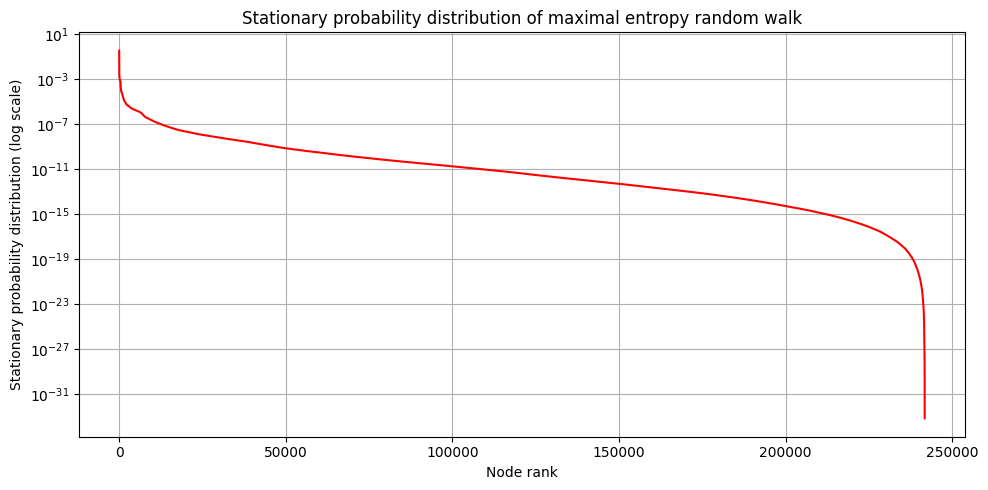

In [9]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh


G_undir = G_scc.to_undirected()

A_sparse = nx.to_scipy_sparse_array(G_undir, format='csr', dtype=float)


lambda_max, psi = eigsh(A_sparse, k=1, which='LA')

psi = psi[:, 0]
psi /= np.linalg.norm(psi)
pi_merw = psi**2
pi_merw /= pi_merw.sum()



plt.figure(figsize=(10, 5))
plt.plot(np.sort(pi_merw)[::-1], c='red')
plt.yscale('log')
plt.title("Stationary probability distribution of maximal entropy random walk")
plt.xlabel("Node rank")
plt.ylabel("Stationary probability distribution (log scale)")
plt.grid(True)
plt.tight_layout()
plt.show()


Top nodes by π_merw: [4429, 2501, 2353, 4697, 5120]


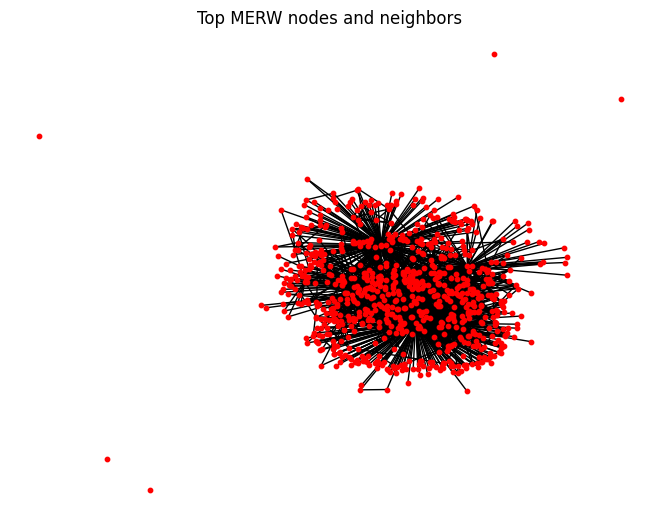

In [10]:
top_k = np.argsort(-pi_merw)[:5]
print("Top nodes by π_merw:", [list(G_undir.nodes())[i] for i in top_k])
sub_nodes = set(top_k)
for node in top_k:
    sub_nodes.update(G_undir.neighbors(list(G_undir.nodes())[node]))
H = G_undir.subgraph(sub_nodes)

pos = nx.spring_layout(H)
nx.draw(H, pos, with_labels=False, node_color='red', node_size = 10)
plt.title("Top MERW nodes and neighbors")
plt.show()


In [11]:
top_k = np.argsort(-pi_merw)[:10]
nodes = list(G_undir.nodes())

for i in top_k:
    node = nodes[i]
    deg = G_undir.degree(node)
    print(f"Node: {node}, πᵢ: {pi_merw[i]:.5f}, degree: {deg}")


Node: 4429, πᵢ: 0.32640, degree: 405
Node: 2501, πᵢ: 0.03821, degree: 194
Node: 2353, πᵢ: 0.03040, degree: 180
Node: 4697, πᵢ: 0.01982, degree: 91
Node: 5120, πᵢ: 0.01951, degree: 95
Node: 5121, πᵢ: 0.01943, degree: 103
Node: 5735, πᵢ: 0.01059, degree: 81
Node: 4431, πᵢ: 0.00950, degree: 65
Node: 6677, πᵢ: 0.00595, degree: 66
Node: 5190, πᵢ: 0.00583, degree: 49


## Rimossione del nodo 4429 a cui corrisponde un valore di MERW fuori dagli ordini di grandezza degli altri nodi

In [12]:

max_index = np.argmax(pi_merw)
nodes = list(G_undir.nodes())
node_to_remove = nodes[max_index]

print(f"Rimuovo il nodo con MERW massimo: {node_to_remove} (πᵢ = {pi_merw[max_index]:.5f})")

G_removed = G_undir.copy()
G_removed.remove_node(node_to_remove)


pi_merw_removed = np.delete(pi_merw, max_index)


print(f"Numero di nodi originale: {G_undir.number_of_nodes()}")
print(f"Numero di nodi dopo rimozione: {G_removed.number_of_nodes()}")

Rimuovo il nodo con MERW massimo: 4429 (πᵢ = 0.32640)
Numero di nodi originale: 241761
Numero di nodi dopo rimozione: 241760


Now i want to start to see if the nodes with higher stationary probability are also part of 'regular' zones. In the following by 'regular' i'll mean surrounded by nodes with similar degree, i.e. with a low degree variance

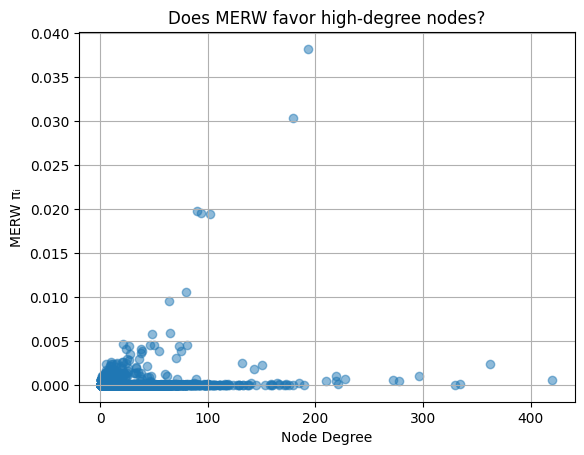

In [9]:
degrees = np.array([G_removed.degree(n) for n in G_removed.nodes()])
plt.scatter(degrees, pi_merw_removed, alpha=0.5)
plt.xlabel("Node Degree")
plt.ylabel("MERW πᵢ")
plt.title("Does MERW favor high-degree nodes?")
plt.grid(True)
plt.show()


## **Local degree entropy**


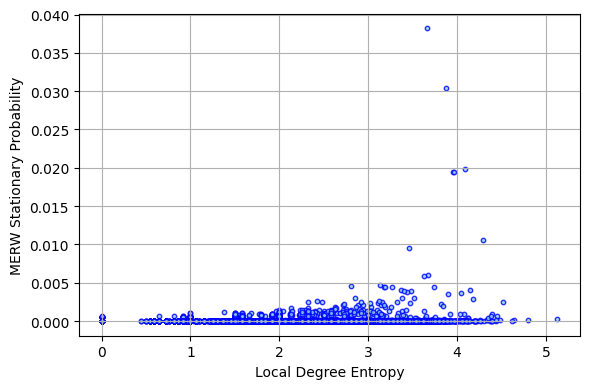

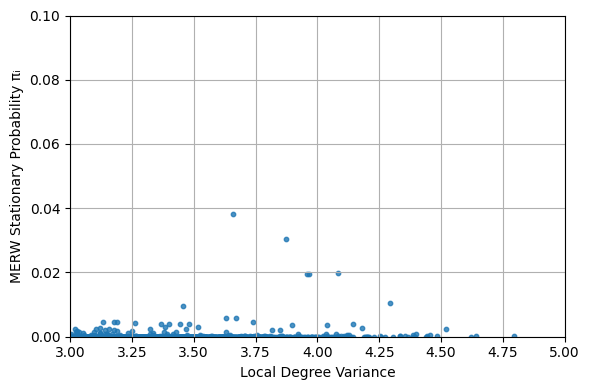

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def local_degree_entropy(G, node):
    neighbors = list(G.neighbors(node))
    if not neighbors:
        return 0
    neighbor_degrees = [G.degree(n) for n in neighbors]
    counts = Counter(neighbor_degrees)
    probs = np.array(list(counts.values())) / len(neighbor_degrees)
    return -np.sum(probs * np.log2(probs))


local_entropy = np.array([local_degree_entropy(G_removed, n) for n in G_removed.nodes()])


plt.figure(figsize=(6, 4))
plt.scatter(local_entropy, pi_merw_removed,
            alpha=0.8, s=10, c='skyblue', edgecolors='blue')
plt.xlabel("Local Degree Entropy")
plt.ylabel("MERW Stationary Probability")
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(6, 4))
plt.scatter(local_entropy, pi_merw_removed, alpha=0.8, s=10)
plt.xlabel("Local Degree Variance")
plt.ylabel("MERW Stationary Probability πᵢ")

plt.grid(True)
plt.ylim(0, 0.10)
plt.xlim(3, 5)
plt.tight_layout()
plt.show()



## **Local clustering coefficient**

Now, i repeat the same analysis but using the local clustering coefficient as criterion for 'regularity'

In [15]:
clustering_dict = nx.clustering(G_removed)
clustering = np.array([clustering_dict[n] for n in G_removed.nodes()])


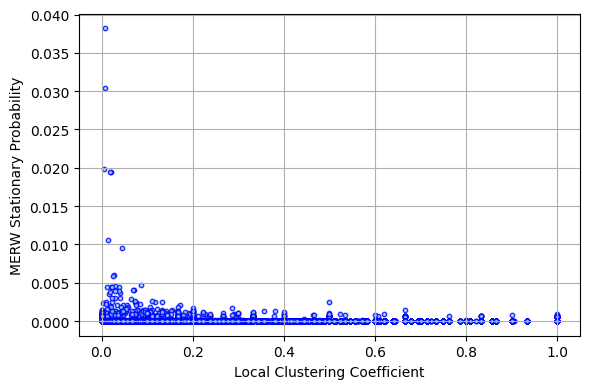

In [16]:
plt.figure(figsize=(6, 4))
plt.scatter(clustering, pi_merw_removed, alpha=0.8, s=10, c='skyblue', edgecolors='blue')
plt.xlabel("Local Clustering Coefficient")
plt.ylabel("MERW Stationary Probability")

plt.grid(True)
plt.tight_layout()
plt.show()


## **Degree centrality**

In [17]:
deg_centrality_dict = nx.degree_centrality(G_removed)
deg_centrality = np.array([deg_centrality_dict[n] for n in G_removed.nodes()])


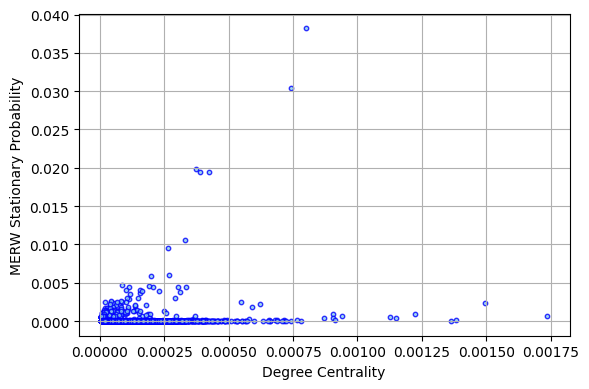

In [18]:
plt.figure(figsize=(6, 4))
plt.scatter(deg_centrality, pi_merw_removed, alpha=0.8, s=10, c='skyblue', edgecolors='blue')
plt.xlabel("Degree Centrality")
plt.ylabel("MERW Stationary Probability")
#plt.title("MERW vs Local Clustering")
plt.grid(True)
plt.tight_layout()
plt.show()

## **Betweenness Centrality**

In [19]:
pip install networkit

In [20]:
import networkit as nk
from tqdm import tqdm

G_nk = nk.nxadapter.nx2nk(G_removed)


n_samples = 1000
est = nk.centrality.EstimateBetweenness(G_nk, n_samples, normalized=False, parallel=False)


est.run()

betweenness_scores = est.scores()


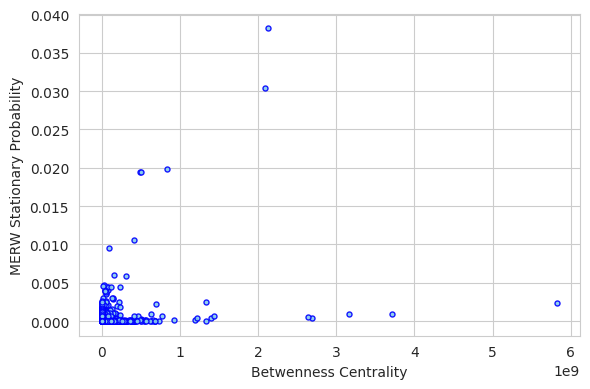

In [21]:
plt.figure(figsize=(6, 4))
plt.scatter(betweenness_scores, pi_merw_removed, alpha=0.9, s=13, c='skyblue', edgecolors='blue')
plt.xlabel("Betwenness Centrality")
plt.ylabel("MERW Stationary Probability")
#plt.title("MERW vs Local Clustering")
plt.grid(True)
plt.tight_layout()
plt.show()

## **Closeness Centrality**

In [22]:
import networkit as nk

G_nk = nk.nxadapter.nx2nk(G_removed)
cl = nk.centrality.ApproxCloseness(G_nk, nSamples=400).run()
closeness = cl.scores()


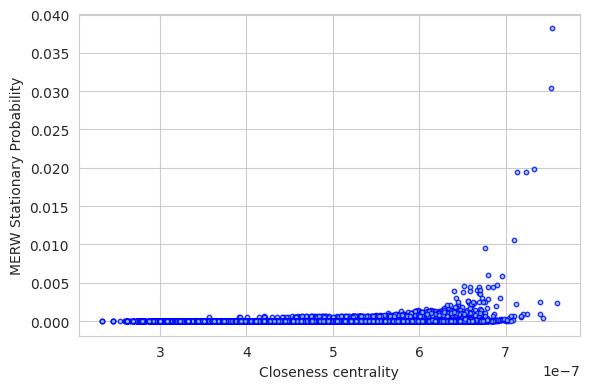

In [23]:
plt.figure(figsize=(6, 4))
plt.scatter(closeness, pi_merw_removed, alpha=0.8, s=10, c='skyblue', edgecolors='blue')
plt.xlabel("Closeness centrality")
plt.ylabel("MERW Stationary Probability")

plt.grid(True)
plt.tight_layout()
plt.show()

## **Katz centrality**

## **Correlazione tra misure di centralità e MERW**

In [34]:
import networkx as nx
import numpy as np
import pandas as pd
from scipy.stats import pearsonr


centralities = {
    "MERW": pi_merw_removed,
    "Degree": deg_centrality,
    "Clustering": clustering,
    "Closeness": closeness,
    "betweenness": betweenness_scores,
    "Local entropy": local_entropy
}


arrays = {}
for name, vals in centralities.items():
    if isinstance(vals, dict):
        arrays[name] = np.array(list(vals.values()))
    else:
        arrays[name] = np.array(vals)


ref_len = len(arrays["MERW"])
problems = {name: len(arr) for name, arr in arrays.items() if len(arr) != ref_len}

if problems:
    print(" Attenzione: alcune centralità NON hanno la stessa lunghezza di MERW:")
    for name, l in problems.items():
        print(f" - {name}: {l} (atteso {ref_len})")
else:
    print("Tutte le centralità hanno la stessa lunghezza.")


    correlations = {}
    for name, arr in arrays.items():
        if name != "MERW":
            corr, _ = pearsonr(arrays["MERW"], arr)
            correlations[name] = corr


    results_df = pd.DataFrame.from_dict(
        correlations, orient="index", columns=["Pearson correlation with MERW"]
    )
    print(results_df)


✅ Tutte le centralità hanno la stessa lunghezza.
               Pearson correlation with MERW
Degree                              0.151463
Clustering                         -0.022191
Closeness                           0.060297
betweenness                         0.321109
Local entropy                       0.029031


In [35]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr


arrays = {}
for name, vals in centralities.items():
    if isinstance(vals, dict):
        arrays[name] = np.array(list(vals.values()))
    else:
        arrays[name] = np.array(vals)


ref_len = len(arrays["MERW"])


for name, arr in arrays.items():
    if len(arr) != ref_len:
        raise ValueError(f" {name} ha lunghezza {len(arr)} invece di {ref_len}")


results = {}
for name, arr in arrays.items():
    if name != "MERW":
        pear_corr, _ = pearsonr(arrays["MERW"], arr)
        spear_corr, _ = spearmanr(arrays["MERW"], arr)
        results[name] = {
            "Pearson": pear_corr,
            "Spearman": spear_corr
        }


results_df = pd.DataFrame(results).T
print(results_df)


                Pearson  Spearman
Degree         0.151463  0.172248
Clustering    -0.022191 -0.325728
Closeness      0.060297  0.931638
betweenness    0.321109  0.423236
Local entropy  0.029031  0.269850


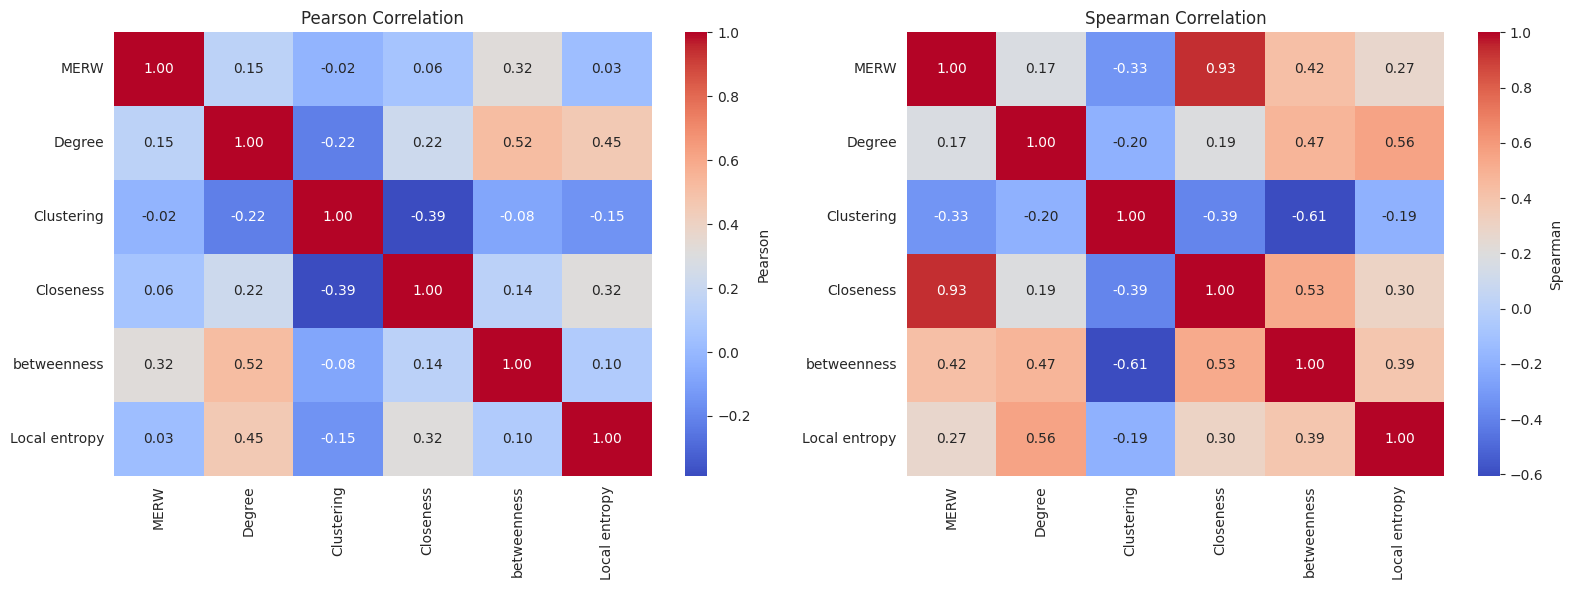

In [36]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
import matplotlib.pyplot as plt


arrays = {}
for name, vals in centralities.items():
    if isinstance(vals, dict):
        arrays[name] = np.array(list(vals.values()))
    else:
        arrays[name] = np.array(vals)


ref_len = len(arrays["MERW"])
for name, arr in arrays.items():
    if len(arr) != ref_len:
        raise ValueError(f"{name} ha lunghezza {len(arr)} invece di {ref_len}")


names = list(arrays.keys())
n = len(names)


pearson_mat = np.zeros((n, n))
spearman_mat = np.zeros((n, n))


for i in range(n):
    for j in range(n):
        pearson_mat[i,j], _ = pearsonr(arrays[names[i]], arrays[names[j]])
        spearman_mat[i,j], _ = spearmanr(arrays[names[i]], arrays[names[j]])

pearson_df = pd.DataFrame(pearson_mat, index=names, columns=names)
spearman_df = pd.DataFrame(spearman_mat, index=names, columns=names)


plt.figure(figsize=(16, 6))

plt.subplot(1,2,1)
sns.heatmap(pearson_df, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label':'Pearson'})
plt.title("Pearson Correlation")

plt.subplot(1,2,2)
sns.heatmap(spearman_df, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label':'Spearman'})
plt.title("Spearman Correlation")

plt.tight_layout()
plt.show()
